In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import simps
from astropy import units as u
from astropy import constants as const

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.ticker as ticker

In [2]:
from agnprocesses import cosmology, synchro, ic, pgamma, bh, gamma_gamma, ebl
from agnprocesses import spectra as spec

# Geometry definition

In [3]:
doppler = 30.0
Gamma = doppler / 2.0
r_b = 1.0e+17 * u.cm
z = 0.3365
d_l = cosmology.luminosity_distance(z).to(u.cm)
print("d_l = {:.6e}".format(d_l))
b = 69.0 * u.g**0.5 * u.cm**(-0.5) * u.s**(-1)
print("B = {:.6e}".format(b))

d_l = 5.643309e+27 cm
B = 6.900000e+01 g(1/2) / (cm(1/2) s)


# External photon field definition

In [4]:
en_ext = np.logspace(np.log10(1.33), np.log10(10.0), 100) * u.eV
en_ext_blob = 4.0 / 3.0 * Gamma * en_ext
boost = 2.0 * 4.0 / 3.0 * Gamma**2
alpha = 2.0
K = 3e+03 / (u.eV * u.cm**3)
n_ext = spec.power_law(en_ext, alpha, norm=K)
n_ext_blob = n_ext * boost
field_ext = np.concatenate(
    (en_ext_blob.value.reshape(en_ext_blob.shape[0], 1),
        n_ext_blob.value.reshape(n_ext_blob.shape[0], 1)),
    axis=1)

# Processes

## Synchrotron

In [5]:
norm_e = 3.8e+38 * u.eV**(-1)
gamma1 = 1.9
gamma2 = 4.4
e_br = 2.0e+08 * u.eV
e_min_e = 5.0e+06 * u.eV
e_max_e = 1.0e+12 * u.eV
e_e = np.logspace(np.log10(e_min_e.to(u.eV).value),
                    np.log10(e_max_e.to(u.eV).value), 100) * u.eV
print("Doppler * e_e_break**2 * B = {:.3e}".format(
    doppler * (e_br / const.m_e.to(e_br.unit, u.mass_energy()))**2 * b
))

synchro_epsilon = np.logspace(-5.5, 4, 1000) * u.eV
nu = (synchro_epsilon / const.h).to(u.Hz)
synchro_spec = synchro.derishev_synchro_spec(
    nu, b,
    norm=norm_e, spec_law='broken_power_law',
    gamma1=gamma1, gamma2=gamma2, en_break=e_br, en_min=e_min_e, en_max=e_max_e
)

Doppler * e_e_break**2 * B = 3.171e+08 g(1/2) / (cm(1/2) s)


## SSA

In [6]:
ssa_tau = synchro.ssa_broken_power_law(
    synchro_epsilon, b, norm_e, gamma1, gamma2, e_br, r_b
)
ssa_abs_coeff = synchro.dermer_sphere_absorption_coefficient(ssa_tau)

synchro_spec = synchro_spec * ssa_abs_coeff
synchro_density = synchro_spec / (4.0 / 3.0 * np.pi * r_b**2 * const.c.to(
    u.cm / u.s)
)
field_synchro = spec.create_2column_table(synchro_epsilon, synchro_density)
synchro_e = synchro_epsilon / (1.0 + z) * doppler
synchro_sed = synchro_epsilon**2 * synchro_spec
synchro_sed = synchro_sed * doppler**4 / (4.0 * np.pi * d_l**2)

## Inverse Compton effect

In [7]:
ic_e = np.logspace(0, 11.5, 100) * u.eV
ic_spec = ic.inverse_compton_spec(
    ic_e,
    field_synchro,
    norm=norm_e,
    spec_law="broken_power_law",
    gamma1=gamma1,
    gamma2=gamma2,
    en_break=e_br,
    en_min=e_min_e,
    en_max=e_max_e,
    background_photon_energy_unit=en_ext_blob.unit,
    background_photon_density_unit=n_ext_blob.unit,
)
ic_sed = ic_e ** 2 * ic_spec
ic_e *= doppler / (1.0 + z)
ic_sed *= doppler ** 4 / (4.0 * np.pi * d_l ** 2)
print("ic_sed.unit = {}".format(ic_sed.unit))
summ_e, summ_sed = spec.summ_spectra(synchro_e, synchro_sed, ic_e, ic_sed, nbin=100)


ic_sed.unit = eV / (cm2 s)


## Photo-hadron processes

### Proton spectrum

In [8]:
energy_proton_min = 1.0e14 * u.eV  # 3.0e+14 * u.eV
energy_proton_max = 6.0e14 * u.eV
en_p = energy_proton_min.unit * np.logspace(
    np.log10(energy_proton_min.to(u.eV).value), np.log10(energy_proton_max.to(u.eV).value), 100
)
p_p = 2.0
C_p = 2.5e65 * u.eV**(-1)
print("C_p = {:.6e}".format(C_p))
proton_spectrum = spec.power_law(en_p, p_p, norm=C_p, en_ref=1.0 * u.eV)
u_p = (
    simps(proton_spectrum.value * en_p.value, en_p.value)
    * proton_spectrum.unit
    * en_p.unit**2
    / (4.0 / 3.0 * np.pi * r_b**3)
)
u_p = u_p.to(u.erg / u.cm**3)
print("proton energy density in the blob = {:.6e}".format(u_p))
L_p = np.pi * r_b**2 * const.c.cgs * (doppler / 2.0)**2 * u_p
print("observable proton luminosity in the lab frame = {:.6e}".format(L_p))
u_b = (b**2 / (8.0 * np.pi)).to(u.erg / u.cm**3)
print("magnetic field density in the blob = {:.6e}".format(u_b))


C_p = 2.500000e+65 1 / eV
proton energy density in the blob = 1.713333e+02 erg / cm3
observable proton luminosity in the lab frame = 3.630737e+49 erg / s
magnetic field density in the blob = 1.894342e+02 erg / cm3


### Photo-hadron process

In [9]:
(
    neutrino_e, neutrino_sed, helectron_e, helectron_sed, hgamma_e, hgamma_sed
) = pgamma.kelner_pgamma_calculate(
    field_ext, energy_proton_min, energy_proton_max, p_p, e_cut_p=-1, C_p=C_p
)

### First hadron synchro

In [10]:
first_hadron_electron = spec.create_2column_table(helectron_e, helectron_sed)
first_synchro_e = np.logspace(7.0, 12.0, 100) * u.eV
nu_first_synchro = (first_synchro_e / const.h).to(u.Hz)
first_synchro_spec = synchro.derishev_synchro_table(
    nu_first_synchro,
    first_hadron_electron,
    b=b,
    electron_energy_unit=helectron_e.unit,
    electron_sed_unit=helectron_sed.unit,
    number_of_integration=100,
    particle_mass=const.m_e.cgs,
    particle_charge=const.e.gauss
)
y = ((const.h * nu_first_synchro).to(u.eV) * first_synchro_spec)
x = first_synchro_e
first_synchro_full_energy = simps(y.value, x.value) * y.unit * x.unit
helectron_full_energy = simps(
    (helectron_sed / helectron_e).value, helectron_e.value
) * helectron_sed.unit
t_cool0 = helectron_full_energy / first_synchro_full_energy
first_synchro_full_energy = first_synchro_full_energy * t_cool0
first_synchro_sed = first_synchro_e**2 * first_synchro_spec
first_synchro_e = first_synchro_e * doppler / (1.0 + z)
first_synchro_sed = first_synchro_sed * \
    doppler**4 / (4.0 * np.pi * d_l**2)
first_synchro_sed = first_synchro_sed * t_cool0

### Hadron gamma-gamma pairs

In [11]:
# External photon field
en_ext2 = np.logspace(np.log10(1.33), np.log10(10.0), 1000) * u.eV
en_ext_blob2 = 4.0 / 3.0 * Gamma * en_ext2
boost = 2.0 * 4.0 / 3.0 * Gamma**2
alpha = 2.0
K = 3e+03 / (u.eV * u.cm**3)
n_ext2 = spec.power_law(en_ext2, alpha, norm=K)
n_ext_blob2 = n_ext2 * boost
field_ext2 = np.concatenate(
    (
        en_ext_blob2.value.reshape(en_ext_blob2.shape[0], 1),
        n_ext_blob2.value.reshape(n_ext_blob2.shape[0], 1)
    ),
    axis=1
)

In [12]:
gamma = np.concatenate(
    (hgamma_e.value.reshape(hgamma_e.shape[0], 1),
    hgamma_sed.value.reshape(hgamma_sed.shape[0], 1)),
    axis=1
)

hadpair_e, hadpair_sed = gamma_gamma.pair_production(
    field_synchro,
    gamma,
    background_photon_energy_unit=en_ext_blob.unit,
    background_photon_density_unit=n_ext_blob.unit,
    gamma_energy_unit=hgamma_e.unit,
    gamma_sed_unit=hgamma_sed.unit
)

second_electron = np.concatenate(
    (
        hadpair_e.value.reshape(hadpair_e.shape[0], 1),
        hadpair_sed.value.reshape(hadpair_sed.shape[0], 1)
    ),
    axis=1
)

second_synchro_e = np.logspace(5.0, 12.0, 100) * u.eV
nu_second_synchro = (second_synchro_e / const.h).to(u.Hz)
second_synchro_spec = synchro.derishev_synchro_table(
    nu_second_synchro,
    second_electron,
    b=b,
    electron_energy_unit=hadpair_e.unit,
    electron_sed_unit=hadpair_sed.unit,
    number_of_integration=100,
    particle_mass=const.m_e.cgs,
    particle_charge=const.e.gauss
)
y = ((const.h * nu_second_synchro).to(u.eV) * second_synchro_spec)
x = second_synchro_e
second_synchro_full_energy = simps(y.value,
                                    x.value) * y.unit * x.unit
hadpair_full_energy = simps((hadpair_sed / hadpair_e).value,
                            hadpair_e.value) * hadpair_sed.unit
t_cool2 = hadpair_full_energy / second_synchro_full_energy
second_synchro_full_energy = second_synchro_full_energy * t_cool2
second_synchro_sed = second_synchro_e**2 * second_synchro_spec
second_synchro_e = second_synchro_e * doppler / (1.0 + z)
second_synchro_sed = second_synchro_sed * doppler**4 / (4.0 * np.pi * d_l**2)
second_synchro_sed = second_synchro_sed * t_cool2

In [13]:
hadpair_e = hadpair_e * doppler / (1.0 + z)
hadpair_sed = hadpair_sed * doppler**4 / (4.0 * np.pi * d_l**2)

In [15]:
neutrino_e = neutrino_e * doppler / (1.0 + z)
neutrino_sed = neutrino_sed * doppler**4 / (4.0 * np.pi * d_l**2)
helectron_e = helectron_e * doppler / (1.0 + z)
helectron_sed = helectron_sed * doppler**4 / (4.0 * np.pi * d_l**2)
hgamma_e = hgamma_e * doppler / (1.0 + z)
hgamma_sed = hgamma_sed * doppler**4 / (4.0 * np.pi * d_l**2)

### Bethe-Heitler process

In [16]:
bh_pair_e, bh_pair_sed = bh.kelner_bh_calculate(
    field_ext,
    energy_proton_min,
    energy_proton_max,
    p_p, e_cut_p=-1,
    C_p=C_p,
)

electron = np.concatenate(
    (
        bh_pair_e.value.reshape(bh_pair_e.shape[0], 1),
        bh_pair_sed.value.reshape(bh_pair_sed.shape[0], 1)
    ),
    axis=1
)

### BH synchro

In [17]:
nu_bh = (np.logspace(0.5, 12.0, 100) * u.eV / const.h).to(u.Hz)
bh_synchro_spec = synchro.derishev_synchro_table(
    nu_bh,
    electron,
    b=b,
    electron_energy_unit=bh_pair_e.unit,
    electron_sed_unit=bh_pair_sed.unit,
    number_of_integration=100,
    particle_mass=const.m_e.cgs,
    particle_charge=const.e.gauss
)
y = ((const.h * nu_bh).to(u.eV) * bh_synchro_spec)
x = (const.h * nu_bh).to(u.eV)
bh_synchro_full_energy = simps(y.value,
                                x.value) * y.unit * x.unit
bh_pair_full_energy = simps((bh_pair_sed / bh_pair_e).value,
                            bh_pair_e.value) * bh_pair_sed.unit
t_cool = bh_pair_full_energy / bh_synchro_full_energy
bh_synchro_full_energy = bh_synchro_full_energy * t_cool
print("t_cool = {:.2e}".format(t_cool))
print("bh_synchro_full_energy = {:.2e}".format(bh_synchro_full_energy))
print("bh_pair_full_energy = {:.2e}".format(bh_pair_full_energy))
bh_pair_e = bh_pair_e * doppler / (1.0 + z)
bh_pair_sed = bh_pair_sed * doppler**4 / (4.0 * np.pi * d_l**2)
print("bh_pair_sed.unit = {}".format(bh_pair_sed.unit))
bh_synchro_e = (nu_bh * const.h).to(u.eV)
bh_synchro_sed = bh_synchro_spec * bh_synchro_e**2
bh_synchro_e = bh_synchro_e * doppler / (1.0 + z)
bh_synchro_sed = bh_synchro_sed * doppler**4 / (4.0 * np.pi * d_l**2)
bh_synchro_sed = bh_synchro_sed * t_cool
print("bh_synchro_sed.unit = {}".format(bh_synchro_sed.unit))

t_cool = 1.60e-01 s
bh_synchro_full_energy = 1.32e+53 eV / s
bh_pair_full_energy = 1.32e+53 eV / s
bh_pair_sed.unit = eV / (cm2 s)
bh_synchro_sed.unit = eV / (cm2 s)


## Experimental data

### $\gamma$-rays

In [18]:
from agnprocesses.data_files import SCIENCE_2018_EXAMPLE_DATA
data = np.loadtxt(SCIENCE_2018_EXAMPLE_DATA)
data_en = data[:, 0]
data_sed = data[:, 1]
data_low = data[:, 3]
data_up = data[:, 2]
yerr = [data_low, data_up]

### Neutrino

In [19]:
# observation of the neutriono flare
science_flare_neutrino_intensity = 1.8e-10 / 1.602e-12 * u.eV / (u.cm**2 * u.s)
# Assuming 10 events per year as Strotjohann et al. assumed
I_min = 2.0e-02 * science_flare_neutrino_intensity / 2.0 / 2.5**2
I_max = 2.5e+00 * science_flare_neutrino_intensity / 2.0 / 2.5**2
I_med = 2.0e-01 * science_flare_neutrino_intensity / 2.0 / 2.5**2
print("I_min = {:.3e}, I_med = {:.3e}, I_max = {:.3e}".format(
    I_min, I_med, I_max
))
E_neu_min = 2.0e+14 * u.eV
E_neu_max = 7.5e+15 * u.eV
E_neu_med = 3.11e+14 * u.eV
C_neu_min = I_min
C_neu_max = I_max
C_neu_med = I_med
E_neu_min_max_long = np.logspace(np.log10(E_neu_min.value),
                                    np.log10(E_neu_max.value)) * E_neu_min.unit
C_neu_median_long = np.ones((50, 1)) * I_med
C_neu_min_max_long = np.logspace(np.log10(C_neu_min.value),
                                    np.log10(C_neu_max.value)) * C_neu_min.unit
E_neu_average_long = np.ones((50, 1)) * E_neu_med

I_min = 1.798e-01 eV / (cm2 s), I_med = 1.798e+00 eV / (cm2 s), I_max = 2.247e+01 eV / (cm2 s)


# Summing spectra and applying absorption effects

In [21]:
summ_e, summ_sed = spec.summ_spectra(synchro_e, synchro_sed, bh_synchro_e, bh_synchro_sed)
summ_e, summ_sed = spec.summ_spectra(summ_e, summ_sed, second_synchro_e, second_synchro_sed)
summ_e, summ_sed = spec.summ_spectra(summ_e, summ_sed, first_synchro_e, first_synchro_sed)

summ_sed = summ_sed * np.exp(-ebl.tau_gilmore(summ_e, z))

In [23]:
e_rate_min = 3.0e+09 * u.eV
e_rate_max = 3.0e+14 * u.eV
e_r_synchro, rate_synchro = gamma_gamma.interaction_rate(
    field_synchro, e_rate_min, e_rate_max,
    background_photon_energy_unit=synchro_epsilon.unit,
    background_photon_density_unit=synchro_density.unit
)
e_r_ext, rate_ext = gamma_gamma.interaction_rate(
    field_ext2, e_rate_min, e_rate_max,
    background_photon_energy_unit=en_ext_blob.unit,
    background_photon_density_unit=n_ext_blob.unit
)
tau_int_synchro = r_b * rate_synchro
tau_int_ext = r_b * rate_ext

rate = spec.to_current_energy(summ_e * (1.0 + z) / doppler,
                                e_r_ext,
                                rate_ext)
tau_internal = rate * r_b

# Plotting results

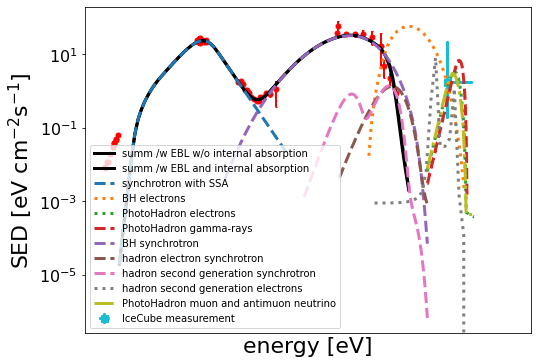

In [25]:
summ_filter = (summ_e < 2.0 * u.TeV)

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(
    summ_e[summ_filter], summ_sed[summ_filter],
    marker=None, linestyle='-', linewidth=3, color='k',
    label='summ /w EBL w/o internal absorption'
)

summ_sed = summ_sed * np.exp(-tau_internal)
ax.plot(
    summ_e[summ_filter], summ_sed[summ_filter],
    marker=None, linestyle='-', linewidth=3, color='k',
    label='summ /w EBL and internal absorption'
)
ax.plot(
    synchro_e, synchro_sed,
    marker=None, linestyle='--', linewidth=3, # color='r',
    label='synchrotron with SSA'
)
# ax.plot(
#     ic_e, ic_sed,
#     marker=None, linewidth=3, linestyle='--', # color='b',
#     label='SSC'
# )
ax.plot(
    bh_pair_e, bh_pair_sed,
    marker=None, linewidth=3, linestyle=':', # color='g',
    label='BH electrons'
)
ax.plot(
    helectron_e, helectron_sed,
    marker=None, linewidth=3, linestyle=':', # color='g',
    label='PhotoHadron electrons'
)
ax.plot(
    hgamma_e, hgamma_sed,
    marker=None, linewidth=3, linestyle='--', # color='g',
    label='PhotoHadron gamma-rays'
)
ax.plot(
    bh_synchro_e, bh_synchro_sed,
    marker=None, linewidth=3, linestyle='--', # color='g',
    label='BH synchrotron'
)
ax.plot(
    first_synchro_e, first_synchro_sed,
    marker=None, linewidth=3, linestyle='--', # color='g',
    label='hadron electron synchrotron'
)
ax.plot(
    second_synchro_e, second_synchro_sed,
    marker=None, linewidth=3, linestyle='--', # color='g',
    label='hadron second generation synchrotron'
)
ax.plot(
    hadpair_e, hadpair_sed,
    marker=None, linestyle=':', linewidth=3, # color='g',
    label='hadron second generation electrons',
    zorder=1000
)

ax.errorbar(
    data_en, data_sed,
    yerr=yerr, xerr=None, fmt='o', linewidth=0, elinewidth=2,
    capsize=1, barsabove=False, markersize=5,
    errorevery=1, capthick=1, color='r', zorder=1.0
)

ax.plot(
    neutrino_e, neutrino_sed,
    marker=None, linewidth=3, linestyle='-.', # color='c',
    label='PhotoHadron muon and antimuon neutrino'
)

ax.errorbar(
    E_neu_med.value, I_med.value,
    yerr=np.array([(I_med - I_min).value, (I_max - I_med).value]).reshape(2, 1),
    xerr=np.array([(E_neu_med - E_neu_min).value, (E_neu_max - E_neu_med).value]).reshape(2, 1),
    fmt='s', linewidth=0, elinewidth=3,
    capsize=1, barsabove=False, markersize=7,
    errorevery=1, capthick=1, zorder=1.0,
    label='IceCube measurement'
)

plt.xlabel('energy [' + str(ic_e.unit) + ']', fontsize=22)
plt.xticks(fontsize=16)
plt.ylabel('SED [' + 'eV cm$^{-2}$s$^{-1}$' + ']', fontsize=22)
plt.yticks(fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_major_locator(ticker.LogLocator(
    base=10.0, numticks=26, subs=[1, 2, 3, 4, 5, 6, 7, 8, 9]))

plt.legend()
plt.show()